In [12]:
import pandas as pd
import numpy as np
import csv
import random
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import math
import operator

In [13]:
def calcManhattan(val1, val2, l):
    dist = 0
    for x in range(l):
        dist += abs(val1[x] - val2[x])
    return (dist)

In [14]:
def getNeighs(trainSet, testSet, k):
    l1 = len(testSet)-1
    l2 = len(trainSet)
    dists = []
    for val in range(l2):
        dist = calcManhattan(testSet, trainSet[val], l1)
        dists.append((trainSet[val], dist))
    dists.sort(key=operator.itemgetter(1))
    neighs = []
    for val in range(k):
        neighs.append(dists[val][0])
    return neighs

In [15]:
def getResps(neighs):
    cVotes = {}
    for val in range(len(neighs)):
        resps = neighs[val][-1]
        if resps in cVotes:
            cVotes[resps] += 1
        else:
            cVotes[resps] = 1
            
    sortVotes = sorted(cVotes.items(), key=operator.itemgetter(1),reverse=True)
    return sortVotes[0][0]

In [16]:
def UpSampling(trainingSet):
    TSet = pd.DataFrame(trainingSet)
    majority_class = []    
    minority_class = []
    TSet = TSet.values.tolist()
   
    for i in range(len(TSet)):
        if TSet[i][-1] == 1:
            majority_class.append(TSet[i])
        else :
            minority_class.append(TSet[i])
       
    unsampled = []
    import random
    n_samples = len(majority_class)-len(minority_class)
    for i in range(n_samples):
        #random.shuffle(minority_class)
        j = 0
        if j < n_samples-1:
            unsampled.append(minority_class[j])
        else:
            j = 0
            unsampled.append(minority_class[j])
        j+=1    
    df_upsampled = pd.DataFrame()
    unsampled = pd.DataFrame(unsampled)
    minority_class = pd.DataFrame(minority_class)
    majority_class = pd.DataFrame(majority_class)
    df_upsampled = pd.concat([minority_class, unsampled])
    df_upsampled = pd.concat([majority_class,df_upsampled])
    df_upsampled = df_upsampled.rename(columns = {16:"class"})
    trainingSet=df_upsampled.values.tolist()
    return trainingSet

In [17]:
def preprocess(train,test):
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    trainingSet = sc.fit_transform(train)
    testSet = sc.transform(test)
    return trainingSet,testSet

In [18]:
def check_file_name(csv_file,df1):
        if(csv_file == "cat2.csv"):
            df2 = df1.drop(labels = ['Unnamed: 0.1','Unnamed: 0', 'galex_objid', 'sdss_objid'],axis = 1)
         
        else:
            df2 = df1.drop(labels=['Unnamed: 0','galex_objid','sdss_objid'],axis = 1)
        return df2

In [19]:
def file_open(csv_file):
    df = pd.read_csv(csv_file)
    class_column = df['class']
    df1 = df.drop(labels=['spectrometric_redshift','class'],axis=1)
    df1['class'] = class_column
    df2 = df1.drop(labels=['pred'],axis=1)
    df2 = check_file_name(csv_file,df2)    
    dataset = df2.values.tolist()
    return dataset

In [20]:
def main():
    
    dataset = file_open("cat1.csv")
    train,test = splitting(dataset)
    
    train = UpSampling(train)
    
    trainingSet,testSet = preprocess(train,test)
    
    
    print ('Train set: ' + repr(len(trainingSet)))
    print ('Test set: ' + repr(len(testSet)))

    a = []
    
    k = 3
    predictions=[]
    for x in range(len(testSet)):
        neighs = getNeighs(trainingSet, testSet[x], k)
        result = getResps(neighs)
        predictions.append(result)

    s = set(predictions)
    s1 = max(s)
    s0 = min(s)

    def getAccuracy(testSet, predictions):
        a=[]
        correct1 = 0
        count1=0
        count0=0
        correct0=0
        for x in range(len(testSet)):
            a.append(testSet[x][-1])
            if testSet[x][-1]==s1:
                count1+=1
                if testSet[x][-1] == predictions[x]: 
                    correct1 = correct1 + 1
            elif testSet[x][-1]==s0:
                count0+=1
                if testSet[x][-1] == predictions[x]: 
                    correct0 = correct0 + 1

        TN = correct0 #stars
        FP = count0-correct0
        FN = count1-correct1
        TP = correct1
        
        acc = (TP+TN)/(TP+TN+FP+FN)
        print('\n')
        print("Overall Accuracy: ",round(acc,2))
        print('\n')
        print("Stars:")
        print("Precision  Recall  F1")
        prec0 = TN/(TN+FN)
        rec0 = TN/(TN+FP)
        f1_0 = 2*prec0*rec0/(prec0+rec0)
        print(round(prec0,2),"      ",round(rec0,2),"  ",round(f1_0,2))
        print('\n')
        print("Quasars:")
        print("Precision  Recall  F1")
        prec1 = TP/(TP+FP)
        rec1 = TP/(TP+FN)
        f1_1 = 2*prec1*rec1/(prec1+rec1)
        print(round(prec1,2),"      ",round(rec1,2),"  ",round(f1_1,2))        
        return a


    b = getAccuracy(testSet, predictions)
    return predictions,b



In [21]:
#data splitting functions

def dataSplit(dataset1,sRatio,trainSz):
    
    trainSet1 = []
    temp_cpy = list(dataset1)
    while len(trainSet1) < trainSz:
        index = random.randrange(len(temp_cpy))
        trainSet1.append(temp_cpy.pop(index))
    return [trainSet1,temp_cpy]
    
def splitting(dataset):
    sRatio = 0.80
    trainSz = int(len(dataset) * sRatio)
    train, test = dataSplit(dataset,sRatio,trainSz)
    return(train,test)

Train set: 942
Test set: 130


Overall Accuracy:  0.99


Stars:
Precision  Recall  F1
1.0        0.83    0.91


Quasars:
Precision  Recall  F1
0.99        1.0    1.0

AUC is  1.0


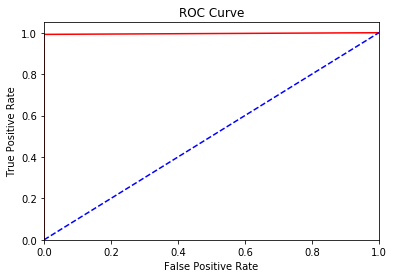

In [22]:
predictions,a = main()
'''k_list = [3,5,7]
plt.plot(k_list,acc_list)
plt.show()'''

x = np.array(predictions)
y = np.array(a)

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(x, y)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], color='blue',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print("\nAUC is ",round(roc_auc,2))
plt.show()